In [1]:
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchsummary import summary
import os
import random
import itertools

In [2]:
def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

seed_everything(42)

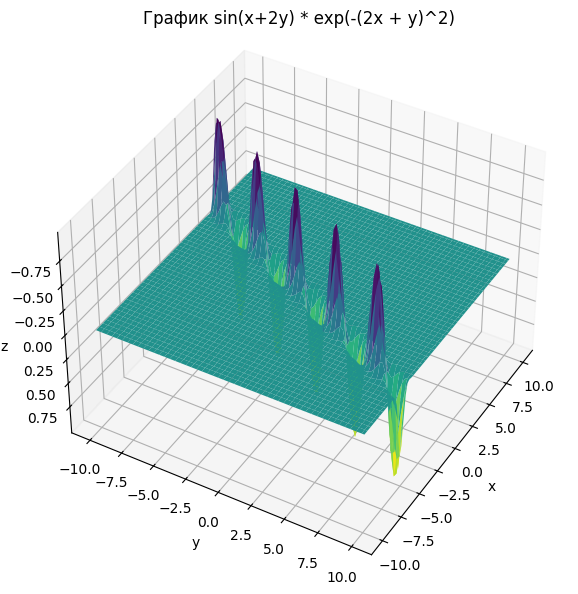

In [3]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X + 2*Y) * np.exp(-(2*X + Y)**2)


fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('График sin(x+2y) * exp(-(2x + y)^2)')
ax.view_init(-140,-30)
plt.show()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X = torch.tensor(np.random.uniform(-10, 10, 20000), dtype=torch.float32)
Y = torch.tensor(np.random.uniform(-10, 10, 20000), dtype=torch.float32)
Z = np.sin(X + 2*Y) * np.exp(-(2*X + Y)**2)

In [6]:
XY = torch.cat((X.unsqueeze(1),Y.unsqueeze(1)), dim=1)
Z = Z.unsqueeze(1)

In [7]:
XY = XY.to(device)
Z = Z.to(device)

In [8]:
XY_len = XY.shape[0]
train_size = int(0.7 * XY_len)
test_size = int(0.15 * XY_len)
val_size = int(0.15 * XY_len)

In [9]:
XY_train = XY[:train_size]
XY_test = XY[train_size:train_size + test_size]
XY_val = XY[train_size + test_size:train_size + test_size+val_size]
Z_train = Z[:train_size]
Z_test = Z[train_size:train_size + test_size]
Z_val = Z[train_size + test_size:train_size + test_size+val_size]
print(f'{XY_train.shape=}, {XY_test.shape=}, {XY_val.shape=}')
print(f'{Z_train.shape=}, {Z_test.shape=}, {Z_val.shape=}')


XY_train.shape=torch.Size([14000, 2]), XY_test.shape=torch.Size([3000, 2]), XY_val.shape=torch.Size([3000, 2])
Z_train.shape=torch.Size([14000, 1]), Z_test.shape=torch.Size([3000, 1]), Z_val.shape=torch.Size([3000, 1])


In [10]:
model = torch.nn.Sequential(    
    torch.nn.Linear(2, 1000), 
    #torch.nn.Linear(2, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(1000, 500),
    torch.nn.ReLU(),    
    torch.nn.Linear(500, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100, 50),
    #torch.nn.Linear(1000, 50),
    torch.nn.Tanh(),
    torch.nn.Linear(50, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1),
)

model.to(device)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(1001):

    model.train()
    optimizer.zero_grad()    
    z_pred = model(XY_train)
    
    loss_train = loss_fn(z_pred, Z_train)

    loss_train.backward()    
    optimizer.step()

    model.eval()
    with torch.no_grad():
        z_pred_test = model(XY_test)
        loss_test = loss_fn(z_pred_test, Z_test)

    if epoch % 50 == 0:
        print(f'epoch={epoch}, loss_train={loss_train.item()}, loss_test={loss_test.item()}') 



epoch=0, loss_train=673.9777221679688, loss_test=242.4417724609375
epoch=50, loss_train=230.8478546142578, loss_test=49.99956130981445
epoch=100, loss_train=227.0406036376953, loss_test=49.24884796142578
epoch=150, loss_train=211.2997283935547, loss_test=45.32660675048828
epoch=200, loss_train=192.0733642578125, loss_test=40.574134826660156
epoch=250, loss_train=170.9900665283203, loss_test=35.814395904541016
epoch=300, loss_train=153.7294464111328, loss_test=32.809574127197266
epoch=350, loss_train=140.17718505859375, loss_test=30.30072784423828
epoch=400, loss_train=118.71194458007812, loss_test=25.76082420349121
epoch=450, loss_train=86.25431823730469, loss_test=19.53919219970703
epoch=500, loss_train=35.835853576660156, loss_test=7.013511657714844
epoch=550, loss_train=11.724019050598145, loss_test=2.7225427627563477
epoch=600, loss_train=7.680019378662109, loss_test=1.828087568283081
epoch=650, loss_train=6.190980911254883, loss_test=1.2429596185684204
epoch=700, loss_train=4.0764

In [11]:
MSE_val = torch.sum((Z_val - model(XY_val))**2)/Z_val.shape[0]
MSE_val.item()

0.00019602233078330755

In [12]:
df = pd.DataFrame(Z.flatten().cpu().numpy())
df[df[0]>0.8]

,0
63,0.911102
138,0.923776
319,0.886386
338,0.999075
545,0.914744
...,...
18953,0.805853
19094,0.958649
19338,0.816118
19402,0.863311


Возьмем изначально сгенерированные 100 точек и посчитаем третью координату для них не по формуле, а из модели. Далее сравним два графика, полученные из формулы и модели

In [13]:
XY_for_graph = [i for i in itertools.product(x,y)]

In [14]:
XY_to_model = torch.FloatTensor(XY_for_graph).to(device)
XY_to_model.shape

torch.Size([10000, 2])

In [15]:
Z_graph = model(XY_to_model)
Z_graph.shape

torch.Size([10000, 1])

In [16]:
Z_graph = Z_graph.view(100,100)
Z_graph = Z_graph.to('cpu').detach().numpy()

In [17]:
X_graph = np.array(XY_for_graph)[:, 0].reshape(100,100)
Y_graph = np.array(XY_for_graph)[:, 1].reshape(100,100)

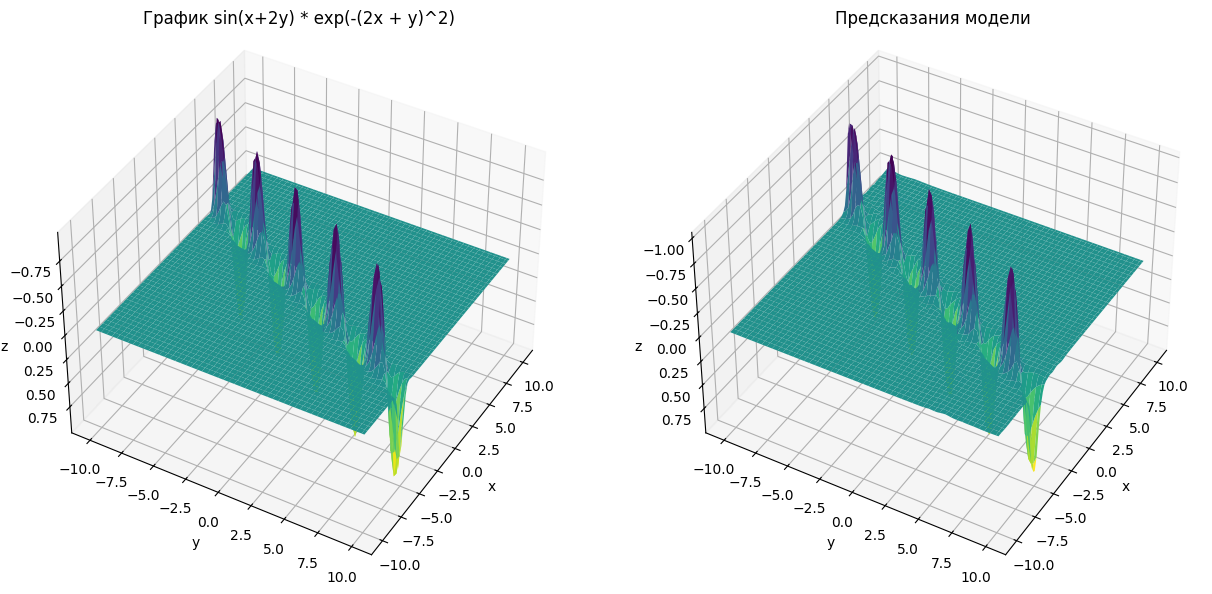

In [18]:
x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(X + 2*Y) * np.exp(-(2*X + Y)**2)

fig = plt.figure(figsize=(30,7))
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1 = fig.add_subplot(111, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.title('График sin(x+2y) * exp(-(2x + y)^2)')
ax1.view_init(-140,-30)

ax2 = fig.add_subplot(122, projection='3d')
surf = ax2.plot_surface(X_graph, Y_graph, Z_graph, cmap='viridis')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
plt.title('Предсказания модели')
ax2.view_init(-140,-30)


plt.show()

Дополнительно проверим не перобучилась ли модель, попробуем построить подобные графики, но на диапазаоне, на котором модель не обучалась [-20;20]. График циклический, вероятно модель, если не переобучилась, должна была установить закономерности

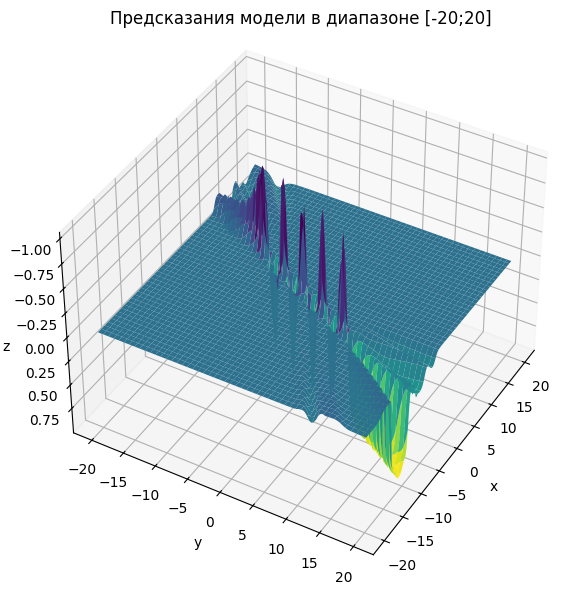

In [19]:
x = np.linspace(-20, 20, 200)
y = np.linspace(-20, 20, 200)

XY_for_graph = [i for i in itertools.product(x,y)]
XY_to_model = torch.FloatTensor(XY_for_graph).to(device)

Z_graph = model(XY_to_model)

Z_graph = Z_graph.view(200,200)
Z_graph = Z_graph.to('cpu').detach().numpy()

X_graph = np.array(XY_for_graph)[:, 0].reshape(200,200)
Y_graph = np.array(XY_for_graph)[:, 1].reshape(200,200)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X_graph, Y_graph, Z_graph, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title('Предсказания модели в диапазоне [-20;20]')
ax.view_init(-140,-30)
plt.show()

Да, действительно, мы просто переобучились. Для улучшения результатов требуется изменить архитектуру и проводить тесты далее, но, к сожалению, сейчас времени на это нет, насколько понял задания из ДЗ выполнены.